# An Improved Evolutionary Multi-Objective Clustering Algorithm Based on Autoencoder

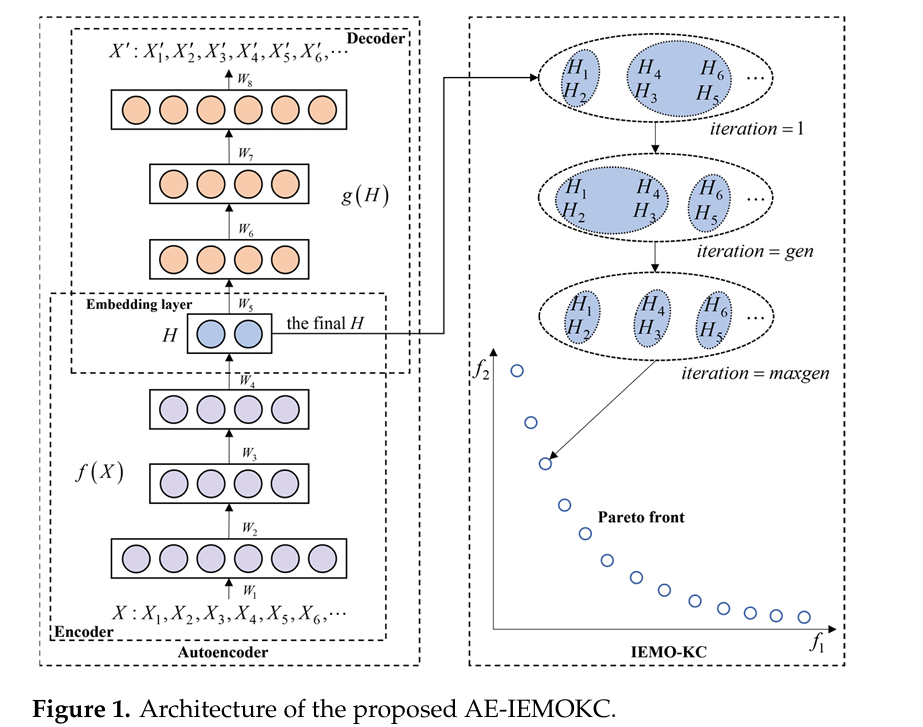

# loading datasets

In [2]:
import pandas as pd

In [3]:
pro_data_mall = pd.read_csv('../Processed_datasets/mall_customer_segmentation/processed_data.csv')
display(pro_data_mall.head())
display(pro_data_mall.info())

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     200 non-null    float64
 1   Annual Income (k$)      200 non-null    float64
 2   Spending Score (1-100)  200 non-null    float64
 3   Gender                  200 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 6.4 KB


None

In [4]:
auto_data_train = pd.read_csv('../Processed_datasets/utomobile_customer_segmentation/train_processed_data.csv')
auto_data_test = pd.read_csv('../Processed_datasets/utomobile_customer_segmentation/test_processed_data.csv')
display("Training set", auto_data_train.head())
display(auto_data_train.info())
display("Testing set", auto_data_test.head())  
display(auto_data_test.info())

'Training set'

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
0,-1.284623,-0.499892,0.757947,1,0,0,5,2,3,3
1,-0.327151,0.537954,0.096095,0,1,1,2,0,3,0
2,1.408268,-0.499892,-1.227610,0,1,1,2,2,5,1
3,1.408268,-0.805141,-0.565758,1,1,1,7,1,5,1
4,-0.207467,1.453700,2.081652,0,1,1,3,1,5,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              8068 non-null   float64
 1   Work_Experience  8068 non-null   float64
 2   Family_Size      8068 non-null   float64
 3   Gender           8068 non-null   int64  
 4   Ever_Married     8068 non-null   int64  
 5   Graduated        8068 non-null   int64  
 6   Profession       8068 non-null   int64  
 7   Spending_Score   8068 non-null   int64  
 8   Var_1            8068 non-null   int64  
 9   Segmentation     8068 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 630.4 KB


None

'Testing set'

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
0,-0.450948,-0.792867,-1.196222,0,1,1,2,2,5
1,-0.391999,1.696957,0.767498,1,1,1,5,0,5
2,1.494372,-0.792867,-1.196222,0,1,0,0,2,5
3,0.904881,2.630641,-0.541649,1,1,0,4,1,5
4,-1.453083,-0.045920,0.767498,0,0,0,8,2,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              2627 non-null   float64
 1   Work_Experience  2627 non-null   float64
 2   Family_Size      2627 non-null   float64
 3   Gender           2627 non-null   int64  
 4   Ever_Married     2627 non-null   int64  
 5   Graduated        2627 non-null   int64  
 6   Profession       2627 non-null   int64  
 7   Spending_Score   2627 non-null   int64  
 8   Var_1            2627 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 184.8 KB


None

# Autoencoder (AE)

- Input → 500 → 500 → 2000 → embedding (d*)
- embedding → 2000 → 500 → 500 → output
- ReLU activations (except final layer)

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


![graphviz (11).png](<attachment:graphviz (11).png>)
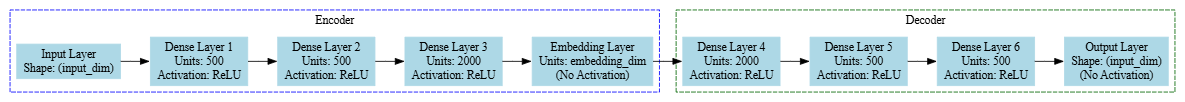
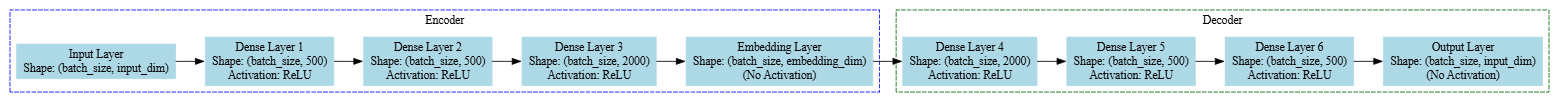

In [6]:

class Autoencoder:
    def __init__(self, input_dim, embedding_dim=3):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.autoencoder, self.encoder, self.decoder = self._build_network()
        
    def _build_network(self):
        # Encoder
        input_layer = Input(shape=(self.input_dim,))
        x = Dense(500, activation='relu')(input_layer)
        x = Dense(500, activation='relu')(x)
        x = Dense(2000, activation='relu')(x)
        embedding = Dense(self.embedding_dim, activation=None)(x)
        
        # Decoder
        x = Dense(2000, activation='relu')(embedding)
        x = Dense(500, activation='relu')(x)
        x = Dense(500, activation='relu')(x)
        output_layer = Dense(self.input_dim, activation=None)(x)
        
        # Models
        autoencoder = Model(input_layer, output_layer)
        encoder = Model(input_layer, embedding)
        
        # Decoder model
        decoder_input = Input(shape=(self.embedding_dim,))
        decoder_output = autoencoder.layers[-4](decoder_input)
        decoder_output = autoencoder.layers[-3](decoder_output)
        decoder_output = autoencoder.layers[-2](decoder_output)
        decoder_output = autoencoder.layers[-1](decoder_output)
        decoder = Model(decoder_input, decoder_output)
        
        return autoencoder, encoder, decoder
    
    def pretrain(self, X, epochs=100, batch_size=32):
        self.autoencoder.compile(optimizer='adam', loss='mse')
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)
        
    def finetune(self, X, k_true, lambda_cluster=0.001, epochs=200, batch_size=32):
        H = self.encoder.predict(X)
        kmeans = KMeans(n_clusters=k_true).fit(H)
        centroids = kmeans.cluster_centers_
        
        def total_loss(y_true, y_pred):
            rec_loss = tf.reduce_mean(tf.square(y_true - y_pred))
            H_pred = self.encoder(y_true)
            dists = tf.stack([tf.reduce_sum(tf.square(H_pred - c), axis=1) for c in centroids])
            min_dists = tf.reduce_min(dists, axis=0)
            cl_loss = tf.square((10.0/(X.shape[0]*self.embedding_dim)) * tf.reduce_sum(min_dists))
            return rec_loss + lambda_cluster * cl_loss
        
        self.autoencoder.compile(optimizer='adam', loss=total_loss)
        self.autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)

## How NSGA works ? 
- Non-dominated Sorting Genetic Algorithm
- NSGA is a multi-objective optimization algorithm that uses a population-based approach to find the Pareto
  
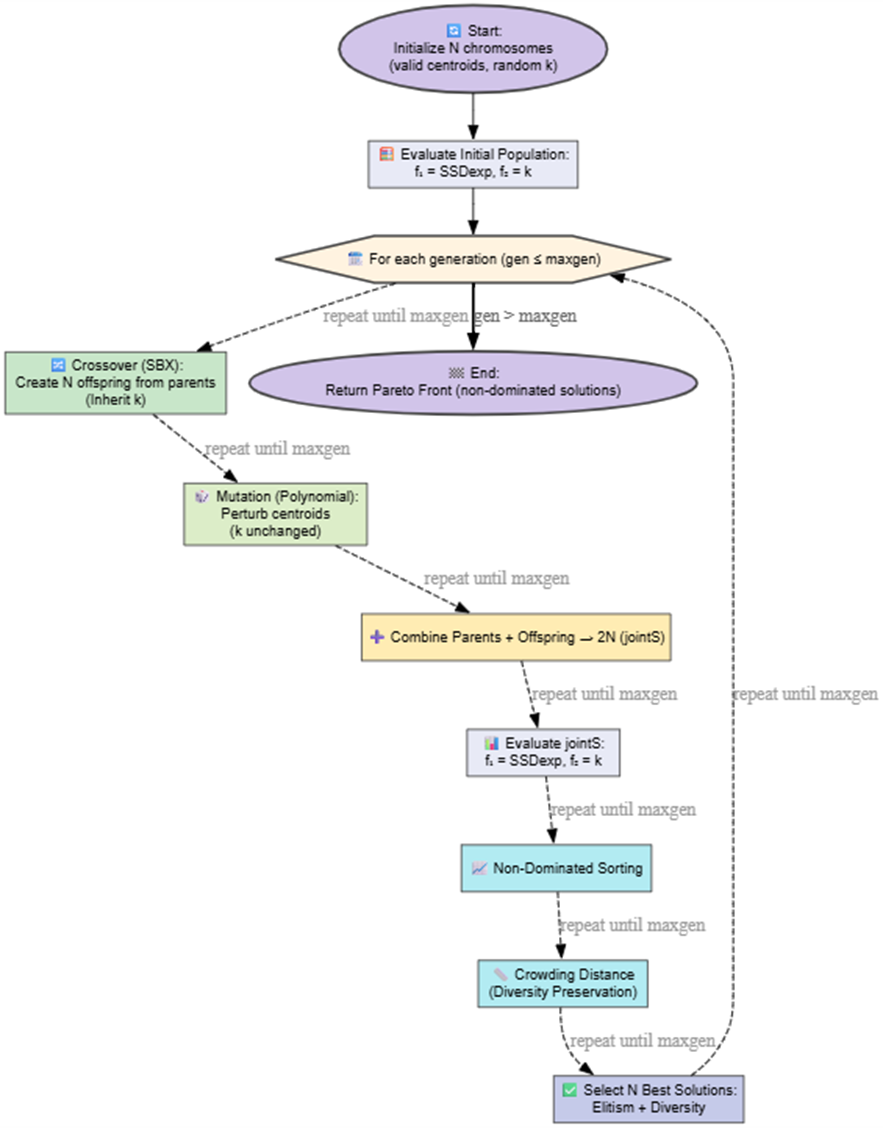


    
1. Initialize N valid chromosomes (solutions), each with:
   - k ∈ [2, kmax]
   - k centroids from H

2. For each generation (up to maxgen):
   a. Generate offspring (OS) using:
      - Simulated Binary Crossover (SBX)
      - Polynomial Mutation (PM)
   
   b. Combine parents + offspring → jointS (size 2N)
   
   c. Evaluate all solutions using:
      - f1(H): SSDexp
      - f2(H): number of clusters (k)
   
   d. Perform non-dominated sorting on jointS → separate into Pareto fronts
   
   e. Use crowding distance to preserve diversity
   
   f. Select N best solutions to form next generation

3. After maxgen generations:
   - Return final non-dominated Pareto front


In [7]:
class IEMOKC:
    def __init__(self, k_range=(2,15), pop_size=100, max_gen=500):
        self.k_min, self.k_max = k_range
        self.pop_size = pop_size
        self.max_gen = max_gen
        
    def _initialize_population(self, data):
        pop = []
        for _ in range(self.pop_size):
            # Valid initialization: select actual data points as centroids
            idx = np.random.choice(len(data), size=self.k_max, replace=False)
            chromosome = data[idx].flatten()
            pop.append(chromosome)
        return np.array(pop)
    
    def _evaluate(self, solution, data, k):
        centroids = solution.reshape(self.k_max, -1)[:k]  # Use first k centroids
        dists = cdist(data, centroids, 'euclidean')
        min_dists = np.min(dists, axis=1)
        ssd = np.sum(min_dists**2)
        
        alpha = 10/(len(data)*data.shape[1])  # Scaling factor
        ssd_exp = (1 - np.exp(-alpha * ssd)) - k
        
        return np.array([ssd_exp, k])
    
    def _non_dominated_sort(self, fitness):
        """Corrected non-dominated sorting implementation"""
        fronts = [[]]
        dominated_counts = [0]*len(fitness)
        dominates = [[] for _ in range(len(fitness))]
        
        for i, f1 in enumerate(fitness):
            for j, f2 in enumerate(fitness):
                if i == j:
                    continue
                # Check if f1 dominates f2 (f1 <= f2 in all objectives and f1 < f2 in at least one)
                if np.all(f1 <= f2) and np.any(f1 < f2):
                    dominates[i].append(j)
                    dominated_counts[j] += 1
            
            if dominated_counts[i] == 0:
                fronts[0].append(i)
                
        current_front = 0
        while fronts[current_front]:
            next_front = []
            for i in fronts[current_front]:
                for j in dominates[i]:
                    dominated_counts[j] -= 1
                    if dominated_counts[j] == 0:
                        next_front.append(j)
            current_front += 1
            fronts.append(next_front)
            
        return fronts[:-1]  # Last one is empty
    
    def _crowding_distance(self, front, fitness):
        distances = [0]*len(front)
        if len(front) == 0:
            return distances
            
        # For each objective
        for m in range(len(fitness[0])):
            # Sort by current objective
            sorted_front = sorted(front, key=lambda x: fitness[x][m])
            # Boundary points get infinite distance
            distances[0] = distances[-1] = float('inf')
            # Normalize objective values
            f_min = fitness[sorted_front[0]][m]
            f_max = fitness[sorted_front[-1]][m]
            if f_max == f_min:
                continue
            norm = f_max - f_min
            # Update distances
            for i in range(1, len(front)-1):
                distances[i] += (fitness[sorted_front[i+1]][m] - fitness[sorted_front[i-1]][m])/norm
        return distances
    
    def _sbx_crossover(self, p1, p2, eta_c=15, pc=1):
        if np.random.rand() > pc:
            return p1.copy(), p2.copy()
            
        u = np.random.rand(len(p1))
        beta = np.where(u <= 0.5,
                      (2*u)**(1/(eta_c+1)),
                      (1/(2*(1-u)))**(1/(eta_c+1)))
        
        child1 = 0.5*((1+beta)*p1 + (1-beta)*p2)
        child2 = 0.5*((1-beta)*p1 + (1+beta)*p2)
        return child1, child2
    
    def _polynomial_mutation(self, x, eta_m=20, pm=None):
        if pm is None:
            pm = 1/len(x)
            
        for i in range(len(x)):
            if np.random.rand() < pm:
                u = np.random.rand()
                delta = np.where(u < 0.5,
                               (2*u)**(1/(eta_m+1)) - 1,
                               1 - (2*(1-u))**(1/(eta_m+1)))
                x[i] += delta
        return x
    def run(self, data):
        # Initialize
        # data -> embedding (H)
        pop = self._initialize_population(data)
        k_values = np.random.randint(self.k_min, self.k_max+1, size=self.pop_size)
        
        for gen in range(self.max_gen):
            # Evaluation - convert k to int for indexing
            fitness = [self._evaluate(pop[i], data, int(k_values[i])) for i in range(self.pop_size)]
            
            # Selection
            fronts = self._non_dominated_sort(fitness)
            selected = []
            remaining = self.pop_size
            for front in fronts:
                if remaining <= 0:
                    break
                if len(front) <= remaining:
                    selected += front
                    remaining -= len(front)
                else:
                    crowding = self._crowding_distance(front, fitness)
                    ranked = sorted(zip(front, crowding), key=lambda x: -x[1])
                    selected += [x[0] for x in ranked[:remaining]]
                    remaining = 0
            
            # Crossover (SBX)
            num_parents = len(selected) - (len(selected) % 2)
            offspring = []
            for i in range(0, num_parents, 2):
                p1, p2 = pop[selected[i]], pop[selected[i+1]]
                child1, child2 = self._sbx_crossover(p1, p2)
                offspring.extend([child1, child2])
            
            # Mutation (Polynomial)
            for i in range(len(offspring)):
                offspring[i] = self._polynomial_mutation(offspring[i])
            
            # Update population - ensure proper array dimensions
            if len(offspring) > 0:
                offspring_array = np.array(offspring)
                new_pop = np.vstack([pop[selected], offspring_array[:self.pop_size-len(selected)]])
                new_k_values = np.concatenate([
                    k_values[selected],
                    k_values[selected[:len(offspring)]]  # Use parents' k values
                ])[:self.pop_size]
            else:
                new_pop = pop[selected]
                new_k_values = k_values[selected]
            
            pop = new_pop[:self.pop_size]
            k_values = new_k_values[:self.pop_size].astype(int)  # Ensure k is integer
        
        # Get Pareto front with integer k values
        final_fitness = [self._evaluate(pop[i], data, k_values[i]) for i in range(self.pop_size)]

        # non-dominated sorting to get the first Pareto front
        fronts = self._non_dominated_sort(final_fitness)

        # Return individuals from the first front
        pareto_front = [(pop[i], final_fitness[i]) for i in fronts[0]]
        return pareto_front


# AE-IEMOKC the wrapper class

![graphviz (9).png](<attachment:graphviz (9).png>)
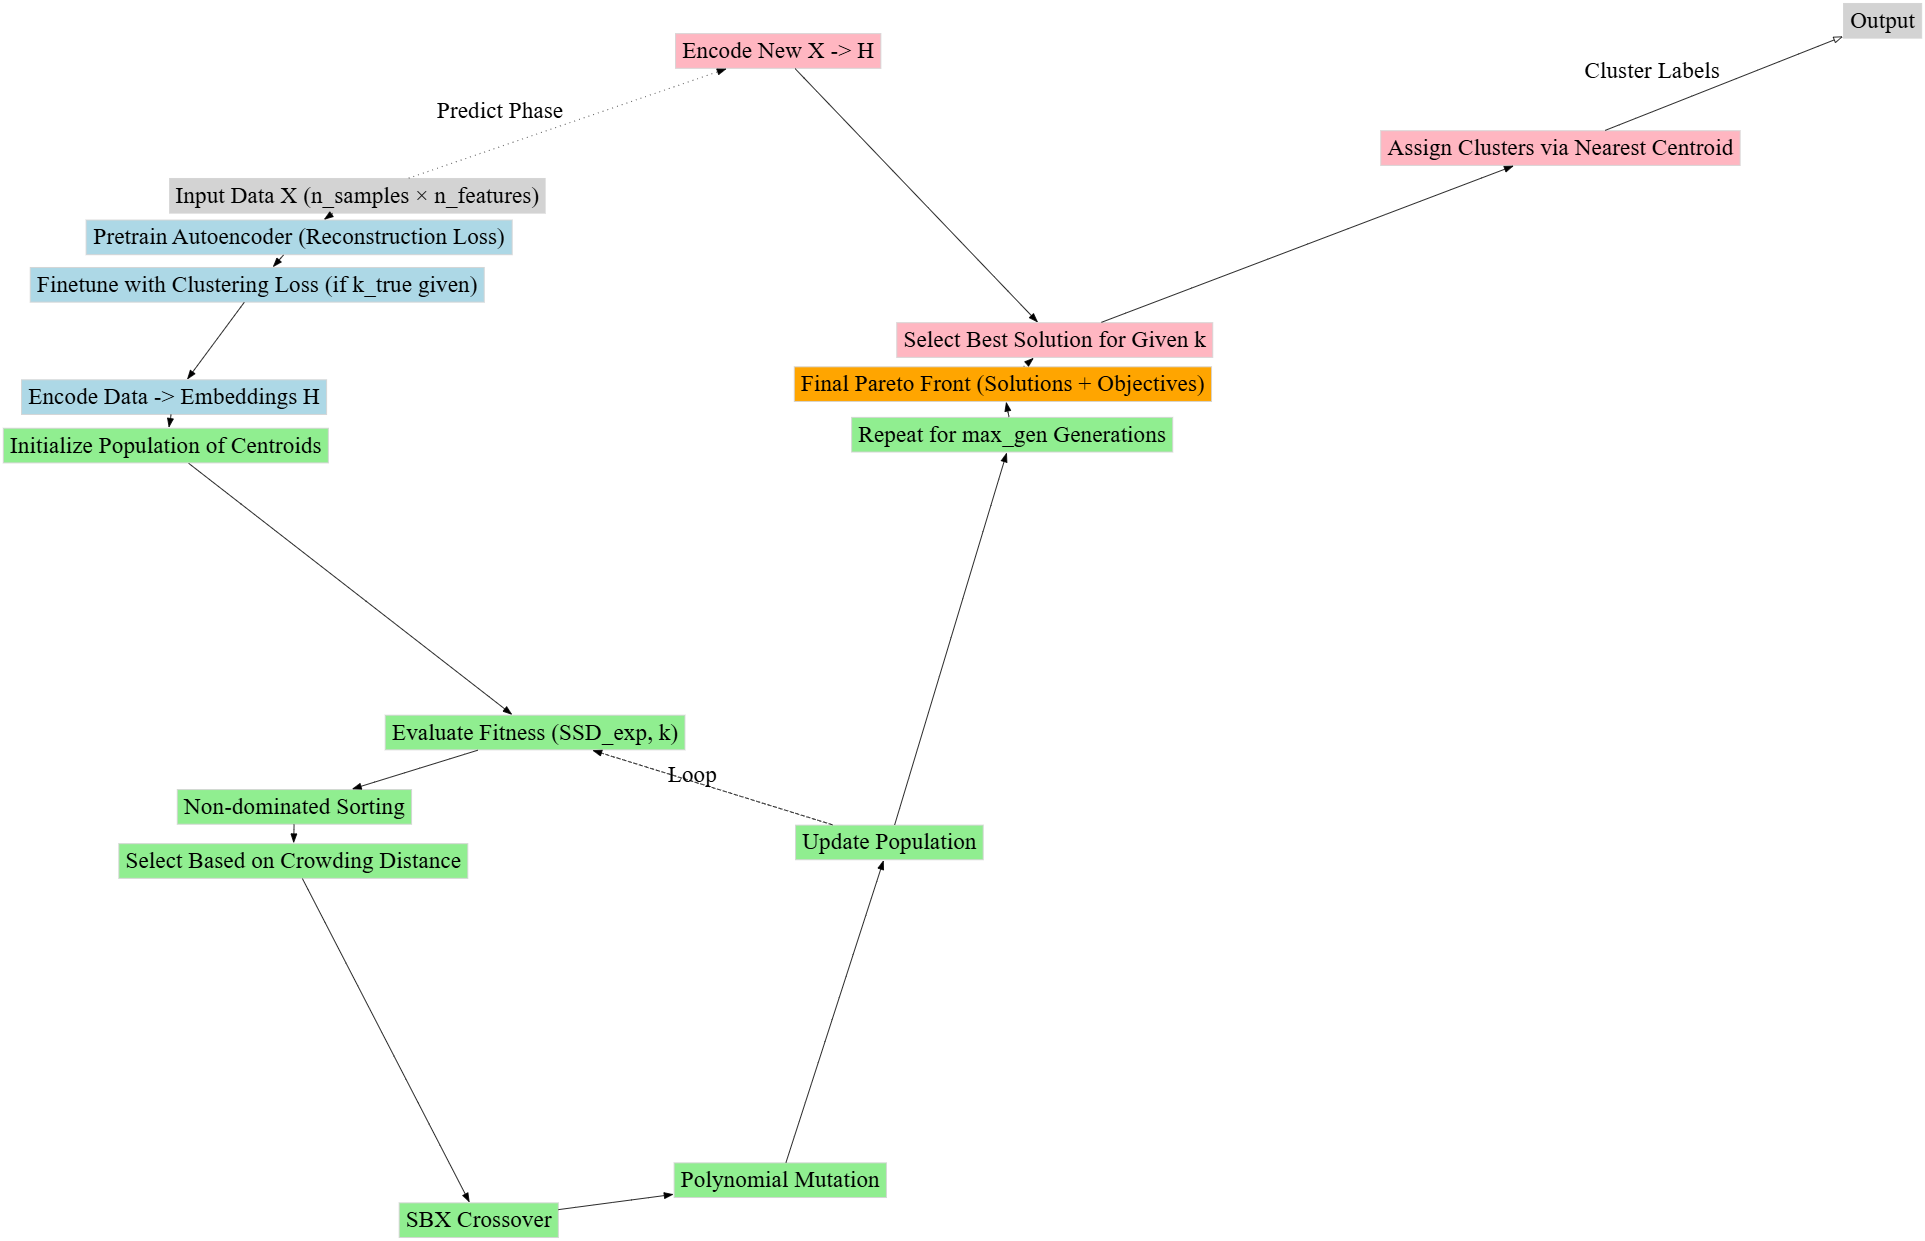

In [8]:
class AEIEMOKC:
    def __init__(self, input_dim=None, embedding_dim=3, k_range=(2,15), 
                 random_state=None, ae_model=None):
        """
        Parameters:
        - ae_model: Pre-trained Autoencoder (optional)
        """
        if ae_model is None:
            self.ae = Autoencoder(input_dim, embedding_dim)
        else:
            self.ae = ae_model
            
        self.random_state = random_state
        self.iemokc = IEMOKC(k_range)
        
        if random_state is not None:
            np.random.seed(self.random_state)
            tf.random.set_seed(self.random_state)

    def fit(self, X, k_true=None, lambda_cluster=0.001, 
            pretrain_epochs=100, finetune_epochs=200):
        """
        Train only if no pre-trained autoencoder was provided
        """
        if not hasattr(self.ae, 'is_trained'):
            # Pretrain
            self.ae.pretrain(X, epochs=pretrain_epochs)
            
            # Finetune if needed
            if lambda_cluster > 0 and k_true is not None:
                self.ae.finetune(X, k_true, lambda_cluster, epochs=finetune_epochs)
            
            self.ae.is_trained = True
        
        # Get embeddings
        H = self.ae.encoder.predict(X)
        
        # Run IEMO-KC
        self.pareto_front = self.iemokc.run(H)
        return self
    
    def get_pareto_front(self):
        return self.pareto_front
    
    def predict(self, X, k):
        H = self.ae.encoder.predict(X)
        solutions = [sol for sol, fit in self.pareto_front if int(fit[1]) == k]
        if not solutions:
            raise ValueError(f"No solution found for k={k}")
            
        best_sol = min(solutions, key=lambda x: self.iemokc._evaluate(x, H, k)[0])
        centroids = best_sol.reshape(self.iemokc.k_max, -1)[:k]
        dists = cdist(H, centroids, 'euclidean')
        return np.argmin(dists, axis=1)

# Example 

In [10]:
# Example usage with proper data scaling
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler
    
    # Generate and scale data
    X, _ = make_blobs(n_samples=300, centers=3, n_features=10, random_state=42)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Initialize and run
    model = AEIEMOKC(input_dim=X.shape[1], embedding_dim=3, k_range=(2,5))
    model.fit(X, k_true=3)
    
    # Get results
    pareto_front = model.get_pareto_front()
    print("Pareto Front Solutions:")
    for sol, (ssd_exp, k) in pareto_front:
        print(f"k={k}, SSD_exp={ssd_exp:.2f}")
    
    # Predict clusters for k=3
    labels = model.predict(X, k=3)
    print("\nCluster labels for k=3:", labels[:10])  # Print first 10 labels




10/10 [==============================] - 0s 2ms/step


c:\Users\msi\anaconda3\envs\testEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\msi\anaconda3\envs\testEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


10/10 [==============================] - 0s 2ms/step
Pareto Front Solutions:
k=4.0, SSD_exp=-3.00
k=5.0, SSD_exp=-4.00
k=2.0, SSD_exp=-1.00
k=4.0, SSD_exp=-3.00
k=5.0, SSD_exp=-4.03
k=3.0, SSD_exp=-2.00
k=4.0, SSD_exp=-3.00
k=3.0, SSD_exp=-2.00
k=3.0, SSD_exp=-2.00
k=4.0, SSD_exp=-3.01
k=4.0, SSD_exp=-3.01
k=3.0, SSD_exp=-2.00
10/10 [==============================] - 0s 2ms/step

Cluster labels for k=3: [1 2 1 2 0 0 2 1 0 2]


In [14]:
# pca
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


10/10 [==============================] - 0s 2ms/step


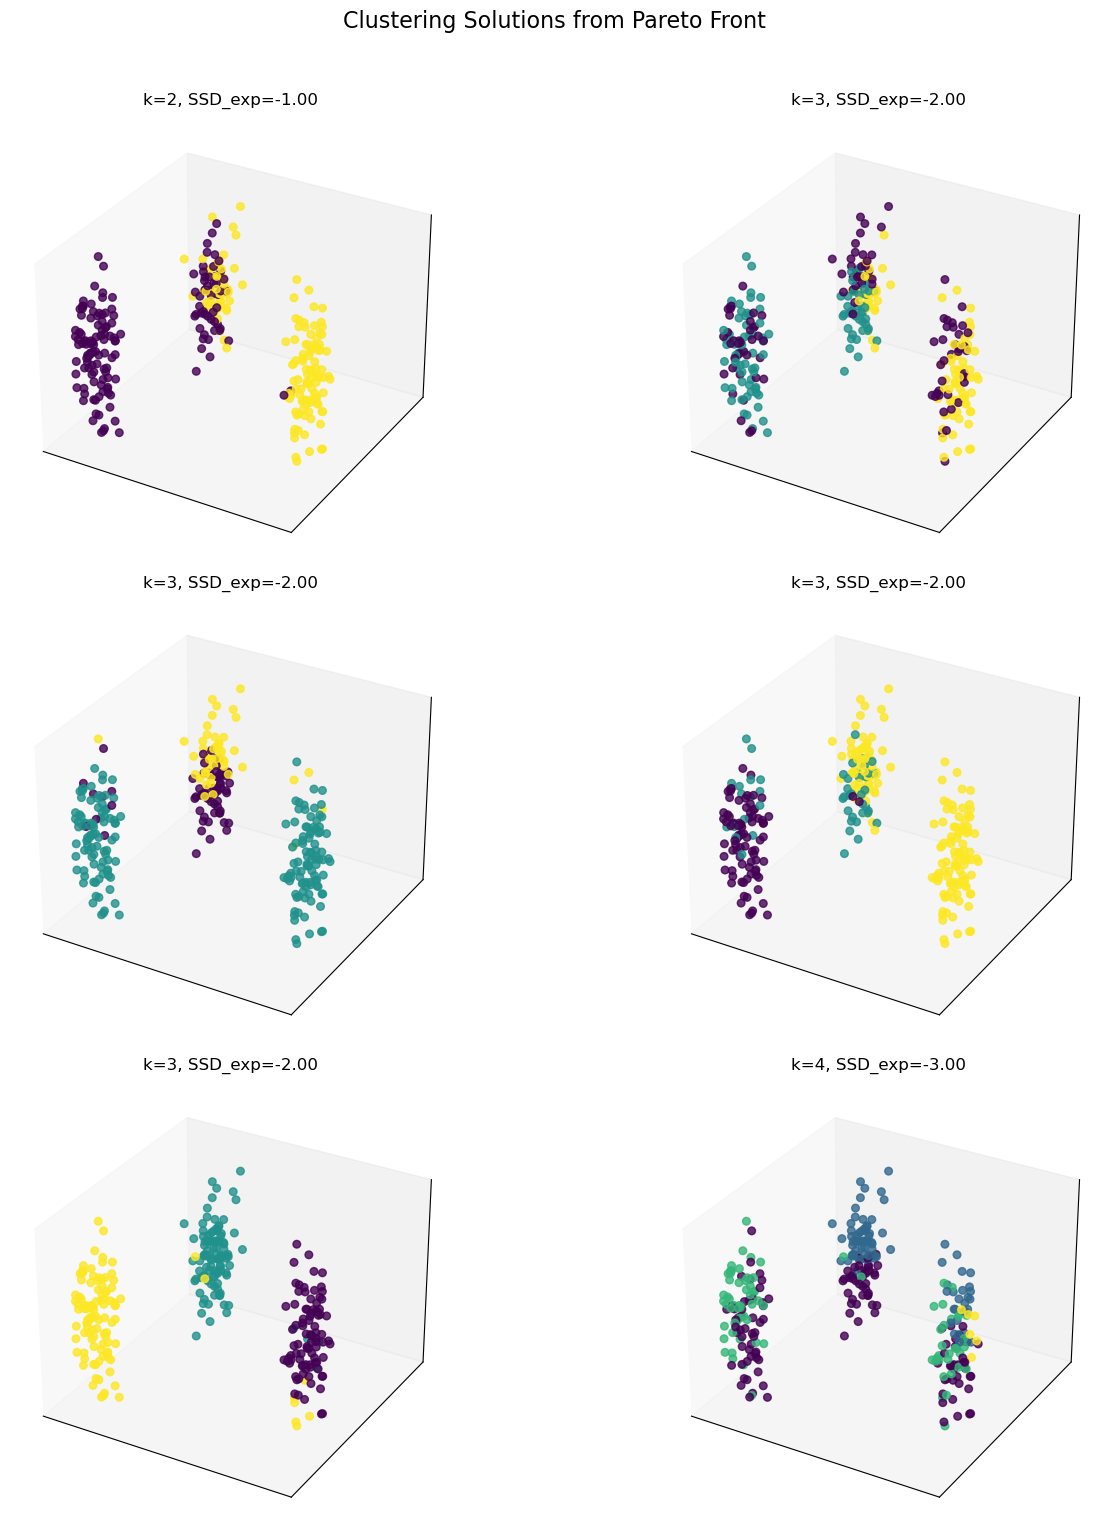

In [15]:
def plot_pareto_solutions(model, X, max_solutions=6):
    # Get PCA projection
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    
    # Get Pareto front solutions
    pareto_front = model.get_pareto_front()
    
    # Sort solutions by k
    pareto_front.sort(key=lambda x: x[1][1])  # Sort by k value
    
    # Limit number of solutions to plot
    n_solutions = min(len(pareto_front), max_solutions)
    
    # Create figure
    n_cols = 2
    n_rows = (n_solutions + n_cols - 1) // n_cols
    fig = plt.figure(figsize=(15, 5*n_rows))
    fig.suptitle('Clustering Solutions from Pareto Front', y=1.02, fontsize=16)
    
    for idx, (sol, (ssd_exp, k)) in enumerate(pareto_front[:n_solutions]):
        # Get cluster labels for this solution
        k_int = int(k)  # Ensure k is integer
        centroids = sol.reshape(model.iemokc.k_max, -1)[:k_int]
        H = model.ae.encoder.predict(X)
        dists = cdist(H, centroids, 'euclidean')
        labels = np.argmin(dists, axis=1)
        
        # Create subplot
        ax = fig.add_subplot(n_rows, n_cols, idx+1, projection='3d')
        
        # Plot points with cluster colors
        scatter = ax.scatter(
            X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
            c=labels, cmap='viridis', s=30, alpha=0.8
        )
        
        # Add title with solution info
        ax.set_title(f'k={k_int}, SSD_exp={ssd_exp:.2f}', pad=10)
        
        # Remove axis ticks for cleaner look
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        # # Add colorbar
        # plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1, label='Cluster')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# After running model.fit(X, k_true=3)
plot_pareto_solutions(model, X)

# Experiments and evaluation

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


class AEIEMOKCExperiment:
    def __init__(self, train_data, eval_data=None, k_range=(2, 10), runs=1, 
                 random_state=None, embedding_dim=3, lambda_cluster=0.001):
        self.train_data = train_data
        self.eval_data = eval_data
        self.k_range = k_range
        self.runs = runs
        self.embedding_dim = embedding_dim
        self.lambda_cluster = lambda_cluster
        self.results = []
        self.random_state = random_state  # Stored as random_state
        self.ae_model = None

        # Set global random seeds if specified
        if self.random_state is not None:
            np.random.seed(self.random_state)
            tf.random.set_seed(self.random_state)


        
    def _calculate_inertia(self, data, centroids, labels):
        return sum(np.min(cdist(data, centroids, 'euclidean'), axis=1)**2)
    
    def _train_autoencoder_once(self):
        """Train autoencoder once and store it"""
        self.ae_model = Autoencoder(
            input_dim=self.train_data.shape[1],
            embedding_dim=self.embedding_dim
        )
        
        train_data = self.train_data.values if hasattr(self.train_data, 'values') else self.train_data
        
        # Pretrain
        self.ae_model.pretrain(train_data, epochs=100)
        
        # Finetune if needed
        if self.lambda_cluster > 0:
            # Using middle of k_range as k_true for fine-tuning
            k_true = (self.k_range[0] + self.k_range[1]) // 2
            self.ae_model.finetune(train_data, k_true, 
                                 self.lambda_cluster, epochs=200)
        
        self.ae_model.is_trained = True
    
    def run(self):
        # Step 1: Train autoencoder once if not already trained
        if self.ae_model is None:
            self._train_autoencoder_once()
        
        # Step 2: Run multiple clustering experiments with same autoencoder
        for run_id in range(self.runs):
            print(f"Running experiment {run_id + 1}/{self.runs}...")
            run_seed = None if self.random_state is None else self.random_state + run_id
            
            if run_seed is not None:
                np.random.seed(run_seed)
                tf.random.set_seed(run_seed)
            
            # Initialize with pre-trained autoencoder
            model = AEIEMOKC(
                k_range=self.k_range,
                random_state=run_seed,
                ae_model=self.ae_model  # Pass the trained autoencoder
            )
            
            # Fit (won't retrain autoencoder)
            model.fit(
                self.train_data.values if hasattr(self.train_data, 'values') else self.train_data,
                k_true=None,
                lambda_cluster=0  # No fine-tuning needed
            )
            
            # Rest of evaluation remains the same...
            pareto_front = model.get_pareto_front()
            print(f"Pareto front size: {len(pareto_front)}")
            
            for sol, (ssd_exp, k) in pareto_front:
                k = int(k)
                train_data = self.train_data.values if hasattr(self.train_data, 'values') else self.train_data
                train_labels = model.predict(train_data, k=k)
                
                # Get centroids in original space
                centroids_embedded = sol.reshape(model.iemokc.k_max, -1)[:k]
                centroids_original = self.ae_model.decoder.predict(centroids_embedded)
                
                # Store results...
                self.results.append({
                    'k': k,
                    'run_id': run_id,
                    'random_seed': run_seed,
                    'dataset': 'train',
                    'inertia': self._calculate_inertia(train_data, centroids_original, train_labels),
                    'ssd_exp': ssd_exp,
                    'silhouette': silhouette_score(train_data, train_labels),
                    'calinski_harabasz': calinski_harabasz_score(train_data, train_labels)
                })
                if self.eval_data is not None:
                    eval_data = self.eval_data.values if hasattr(self.eval_data, 'values') else self.eval_data
                    eval_labels = model.predict(eval_data, k=k)
                    eval_inertia = self._calculate_inertia(eval_data, centroids_original, eval_labels)
                    
                    self.results.append({
                        'k': k,
                        'run_id': run_id,
                        'random_seed': run_seed,
                        'dataset': 'eval',
                        'inertia': eval_inertia,
                        'ssd_exp': ssd_exp,
                        'silhouette': silhouette_score(eval_data, eval_labels),
                        'calinski_harabasz': calinski_harabasz_score(eval_data, eval_labels)
                    })
    
                
    
    def get_results(self):
        return pd.DataFrame(self.results)
    
    def plot_metrics(self, dataset='train'):
        df = self.get_results()
        df = df[df['dataset'] == dataset]
        
        grouped = df.groupby('k').agg({
            'inertia': 'mean',
            'silhouette': 'mean',
            'calinski_harabasz': 'mean',
            'ssd_exp': 'mean'
        }).reset_index()
        
        plt.figure(figsize=(20, 4))
        
        plt.subplot(1, 4, 1)
        plt.plot(grouped['k'], grouped['inertia'], marker='o')
        plt.title(f'Inertia vs k ({dataset})')
        plt.xlabel('k')
        plt.ylabel('Inertia')
        
        plt.subplot(1, 4, 2)
        plt.plot(grouped['k'], grouped['silhouette'], marker='o')
        plt.title(f'Silhouette Score vs k ({dataset})')
        plt.xlabel('k')
        plt.ylabel('Silhouette')
        
        plt.subplot(1, 4, 3)
        plt.plot(grouped['k'], grouped['calinski_harabasz'], marker='o')
        plt.title(f'Calinski-Harabasz vs k ({dataset})')
        plt.xlabel('k')
        plt.ylabel('C-H Score')
        
        plt.subplot(1, 4, 4)
        plt.plot(grouped['k'], grouped['ssd_exp'], marker='o')
        plt.title(f'SSD_exp vs k ({dataset})')
        plt.xlabel('k')
        plt.ylabel('SSD_exp')
        
        plt.tight_layout()
        plt.show()
        
    def get_best_k(self, dataset='train', metric='silhouette'):
        df = self.get_results()
        df = df[df['dataset'] == dataset]
        grouped = df.groupby('k')[metric].mean().reset_index()
        
        if metric in ['silhouette', 'calinski_harabasz']:
            best_row = grouped.loc[grouped[metric].idxmax()]
        else:
            best_row = grouped.loc[grouped[metric].idxmin()]
            
        return best_row['k'], best_row[metric]

In [19]:
pro_data_mall.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


In [20]:
# Initialize experiment
experiment = AEIEMOKCExperiment(
    train_data=pro_data_mall, 
    k_range=(2, 10),
    runs=30,
    random_state=1,
    embedding_dim=3,
    lambda_cluster=0.001
)

# Run the experiment
experiment.run()

# Get results dataframe
results_df_pro = experiment.get_results()

# Get best k based on different metrics
best_k_silhouette, score_sil = experiment.get_best_k(metric='silhouette')
best_k_inertia, score_inertia = experiment.get_best_k(metric='inertia')
best_k_ch, score_ch = experiment.get_best_k(metric='calinski_harabasz')

print(f"Best k by silhouette: {best_k_silhouette} (score: {score_sil:.3f})")
print(f"Best k by inertia: {best_k_inertia} (score: {score_inertia:.3f})")
print(f"Best k by Calinski-Harabasz: {best_k_ch} (score: {score_ch:.3f})")

7/7 [==============================] - 0s 2ms/step


c:\Users\msi\anaconda3\envs\testEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\msi\anaconda3\envs\testEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Running experiment 1/30...
7/7 [==============================] - 0s 3ms/step
Pareto front size: 30
1/1 [==============================] - 0s 25ms/step
Running experiment 2/30...
7/7 [==============================] - 0s 2ms/step
Pareto front size: 30
1/1 [==============================] - 0s 36ms/step
Running experiment 3/30...
7/7 [==============================] - 0s 3ms/step
Pareto front size: 24
1/1 [==============================] - 0s 32ms/step
Running experiment 4/30...
7/7 [==============================] - 0s 3ms/step
Pareto front size: 28
1/1 [==============================] - 0s 30ms/step
Running experiment 5/30...
7/7 [==============================] - 0s 3ms/step
Pareto front size: 25
1/1 [==============================] - 0s 30ms/step
Running experiment 6/30...
7/7 [==============================] - 0s 2ms/step
Pareto front size: 26
1/1 [==============================] - 0s 26ms/step
Running experiment 7/30...
7/7 [==============================] - 0s 2ms/step
Pareto fro

In [21]:
results_df_pro.shape

(822, 8)

In [22]:
results_df_pro.shape

(822, 8)

In [23]:
results_df_pro

,k,run_id,random_seed,dataset,inertia,ssd_exp,silhouette,calinski_harabasz
0,6,0,1,train,420.415760,-5.019585,0.108039,29.729849
1,9,0,1,train,278.635801,-8.047415,0.101951,31.177926
2,3,0,1,train,518.281284,-2.001376,0.206142,57.874243
3,8,0,1,train,456.863573,-7.026139,0.172806,44.585375
4,7,0,1,train,393.382747,-6.016348,0.163705,39.832175
...,...,...,...,...,...,...,...,...
817,4,29,30,train,481.203558,-3.005004,0.140199,36.289034
818,6,29,30,train,283.604017,-5.042606,0.200456,48.918811
819,9,29,30,train,262.146114,-8.069482,0.105784,33.575532
820,10,29,30,train,255.814633,-9.101213,0.159927,39.987505


In [26]:
results_df_pro.to_csv('results_df_pro_AE_IEMOKC.csv', index=False)

In [27]:
auto_data_train.head()

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
0,-1.284623,-0.499892,0.757947,1,0,0,5,2,3,3
1,-0.327151,0.537954,0.096095,0,1,1,2,0,3,0
2,1.408268,-0.499892,-1.227610,0,1,1,2,2,5,1
3,1.408268,-0.805141,-0.565758,1,1,1,7,1,5,1
4,-0.207467,1.453700,2.081652,0,1,1,3,1,5,0


In [28]:
auto_data_test.head()

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1
0,-0.450948,-0.792867,-1.196222,0,1,1,2,2,5
1,-0.391999,1.696957,0.767498,1,1,1,5,0,5
2,1.494372,-0.792867,-1.196222,0,1,0,0,2,5
3,0.904881,2.630641,-0.541649,1,1,0,4,1,5
4,-1.453083,-0.045920,0.767498,0,0,0,8,2,5


In [33]:
# Initialize experiment
experiment = AEIEMOKCExperiment(
    train_data=auto_data_train.drop(columns=['Segmentation']), 
    eval_data=auto_data_test,
    k_range=(2, 10),
    runs=1,
    random_state=1,
    embedding_dim=3,
    lambda_cluster=0.001
)

# Run the experiment
experiment.run()

# Get results dataframe
results_df_auto = experiment.get_results()

# Get best k based on different metrics
best_k_silhouette, score_sil = experiment.get_best_k(metric='silhouette')
best_k_inertia, score_inertia = experiment.get_best_k(metric='inertia')
best_k_ch, score_ch = experiment.get_best_k(metric='calinski_harabasz')

print(f"Best k by silhouette: {best_k_silhouette} (score: {score_sil:.3f})")
print(f"Best k by inertia: {best_k_inertia} (score: {score_inertia:.3f})")
print(f"Best k by Calinski-Harabasz: {best_k_ch} (score: {score_ch:.3f})")

253/253 [==============================] - 0s 2ms/step


c:\Users\msi\anaconda3\envs\testEnv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Running experiment 1/1...
253/253 [==============================] - 1s 2ms/step
Pareto front size: 33
83/83 [==============================] - 0s 2ms/step
Best k by silhouette: 2.0 (score: 0.267)
Best k by inertia: 10.0 (score: 52275.304)
Best k by Calinski-Harabasz: 2.0 (score: 3033.148)


In [35]:
results_df_auto

,k,run_id,random_seed,dataset,inertia,ssd_exp,silhouette,calinski_harabasz
0,10,0,1,train,54264.061109,-9.000000,0.119918,1314.680070
1,10,0,1,eval,17802.548404,-9.000000,0.115996,427.842692
2,8,0,1,train,60926.292851,-7.000000,0.170817,1630.176318
3,8,0,1,eval,20127.155474,-7.000000,0.166035,538.932580
4,4,0,1,train,95455.921801,-3.000000,0.199341,2236.967873
...,...,...,...,...,...,...,...,...
61,3,0,1,eval,27689.612078,-2.000000,0.220056,692.410479
62,7,0,1,train,57428.513268,-6.000003,0.150674,1649.485368
63,7,0,1,eval,18713.996650,-6.000003,0.155486,558.207023
64,2,0,1,train,94321.782202,-1.000000,0.266506,3033.147775


In [36]:
results_df_auto.to_csv('results_df_auto_AE_IEMOKC.csv', index=False)

In [37]:
results_df_auto.drop(columns=["random_seed", "run_id"], inplace=True)

In [42]:
results_df_auto_sum_train = results_df_auto[results_df_auto["dataset"]=="train"].drop(columns="ssd_exp").groupby(['k', 'dataset']).mean().reset_index()
results_df_auto_sum_train

,k,dataset,inertia,silhouette,calinski_harabasz
0,2,train,104847.221535,0.266506,3033.147775
1,3,train,105349.685452,0.214446,2016.829679
2,4,train,83737.011536,0.199341,2236.967873
3,5,train,79923.349256,0.148978,1851.706367
4,6,train,70194.794254,0.102686,1320.490194
5,7,train,63885.141118,0.150674,1649.485368
6,8,train,59111.062015,0.170817,1630.176318
7,9,train,67158.703832,0.130223,1150.017670
8,10,train,52275.304029,0.119918,1314.680070


In [43]:
results_df_auto_sum_eval = results_df_auto[results_df_auto["dataset"]=="eval"].drop(columns="ssd_exp").groupby(['k', 'dataset']).mean().reset_index()
results_df_auto_sum_eval

,k,dataset,inertia,silhouette,calinski_harabasz
0,2,eval,34306.574040,0.277445,1069.050101
1,3,eval,34181.327633,0.220056,692.410479
2,4,eval,27358.683832,0.196588,749.258097
3,5,eval,26007.500825,0.147246,625.084087
4,6,eval,22927.049702,0.098949,441.909888
5,7,eval,20892.948707,0.155486,558.207023
6,8,eval,19261.137477,0.166035,538.932580
7,9,eval,22077.895065,0.121950,377.995776
8,10,eval,17039.824539,0.115996,427.842692


In [44]:
results_df_auto_sum_eval \
    .style \
    .highlight_min(color='pink', subset=['inertia']) \
    .highlight_max(color='lightgreen', subset=['silhouette']) \
    .highlight_max(color='lightgreen', subset=['calinski_harabasz'])


,k,dataset,inertia,silhouette,calinski_harabasz
0,2,eval,34306.574040,0.277445,1069.050101
1,3,eval,34181.327633,0.220056,692.410479
2,4,eval,27358.683832,0.196588,749.258097
3,5,eval,26007.500825,0.147246,625.084087
4,6,eval,22927.049702,0.098949,441.909888
5,7,eval,20892.948707,0.155486,558.207023
6,8,eval,19261.137477,0.166035,538.932580
7,9,eval,22077.895065,0.121950,377.995776
8,10,eval,17039.824539,0.115996,427.842692


In [45]:
results_df_auto_sum_train \
    .style \
    .highlight_min(color='pink', subset=['inertia']) \
    .highlight_max(color='lightgreen', subset=['silhouette']) \
    .highlight_max(color='lightgreen', subset=['calinski_harabasz'])


,k,dataset,inertia,silhouette,calinski_harabasz
0,2,train,104847.221535,0.266506,3033.147775
1,3,train,105349.685452,0.214446,2016.829679
2,4,train,83737.011536,0.199341,2236.967873
3,5,train,79923.349256,0.148978,1851.706367
4,6,train,70194.794254,0.102686,1320.490194
5,7,train,63885.141118,0.150674,1649.485368
6,8,train,59111.062015,0.170817,1630.176318
7,9,train,67158.703832,0.130223,1150.017670
8,10,train,52275.304029,0.119918,1314.680070


In [47]:
df_scaled_5

MinMaxScaler()

In [48]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

metrics = ['inertia', 'silhouette', 'calinski_harabasz']
df_scaled_5 = results_df_auto_sum_train.copy()

# Inertia should be minimized, so we invert it after scaling
scaler = MinMaxScaler()

# Scale silhouette and Calinski-Harabasz (want to maximize)
df_scaled_5[['silhouette', 'calinski_harabasz']] = scaler.fit_transform(results_df_auto_sum_train[['silhouette', 'calinski_harabasz']])

# Scale inertia (then invert to convert into a maximization metric)
df_scaled_5['inertia'] = 1 - scaler.fit_transform(results_df_auto_sum_train[['inertia']])

df_scaled_5['composite_score'] = (
    0.4 * df_scaled_5['inertia'] +
    0.2 * df_scaled_5['silhouette'] +
    0.4 * df_scaled_5['calinski_harabasz']
)
df_scaled_5.style.highlight_max(color='lightgreen', subset=['composite_score']) 



,k,dataset,inertia,silhouette,calinski_harabasz,composite_score
0,2,train,0.009467,1.000000,1.000000,0.603787
1,3,train,0.000000,0.682214,0.460304,0.320564
2,4,train,0.407215,0.590008,0.577204,0.511769
3,5,train,0.479070,0.282577,0.372618,0.397191
4,6,train,0.662370,0.000000,0.090526,0.301159
5,7,train,0.781253,0.292927,0.265233,0.477180
6,8,train,0.871204,0.415888,0.254979,0.533651
7,9,train,0.719575,0.168088,0.000000,0.321447
8,10,train,1.000000,0.105187,0.087441,0.456014


In [49]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

metrics = ['inertia', 'silhouette', 'calinski_harabasz']
df_scaled_6 = results_df_auto_sum_eval.copy()

# Inertia should be minimized, so we invert it after scaling
scaler = MinMaxScaler()

# Scale silhouette and Calinski-Harabasz (want to maximize)
df_scaled_6[['silhouette', 'calinski_harabasz']] = scaler.fit_transform(results_df_auto_sum_eval[['silhouette', 'calinski_harabasz']])

# Scale inertia (then invert to convert into a maximization metric)
df_scaled_6['inertia'] = 1 - scaler.fit_transform(results_df_auto_sum_eval[['inertia']])

df_scaled_6['composite_score'] = (
    0.4 * df_scaled_6['inertia'] +
    0.2 * df_scaled_6['silhouette'] +
    0.4 * df_scaled_6['calinski_harabasz']
)
df_scaled_6.style.highlight_max(color='lightgreen', subset=['composite_score']) 



,k,dataset,inertia,silhouette,calinski_harabasz,composite_score
0,2,eval,0.000000,1.000000,1.000000,0.600000
1,3,eval,0.007254,0.678485,0.454978,0.320590
2,4,eval,0.402386,0.547010,0.537240,0.485252
3,5,eval,0.480639,0.270581,0.357553,0.389393
4,6,eval,0.659043,0.000000,0.092488,0.300612
5,7,eval,0.776847,0.316745,0.260777,0.478399
6,8,eval,0.871353,0.375843,0.232886,0.516864
7,9,eval,0.708221,0.128862,0.000000,0.309061
8,10,eval,1.000000,0.095508,0.072132,0.447954
